In [20]:
import sys
sys.path.append('../')

import jax
# set jax precision 64 bit
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from src.signalprocessing import iF, F
from src.trees import get_1d_tree, get_data_1d, plot_1d_tree, is_far, flatten_around_point, plot_1d_tree, data_plotter
from src.particles import nodes_to_array, potential_from_array, potential_from_points
import jax.numpy as jnp

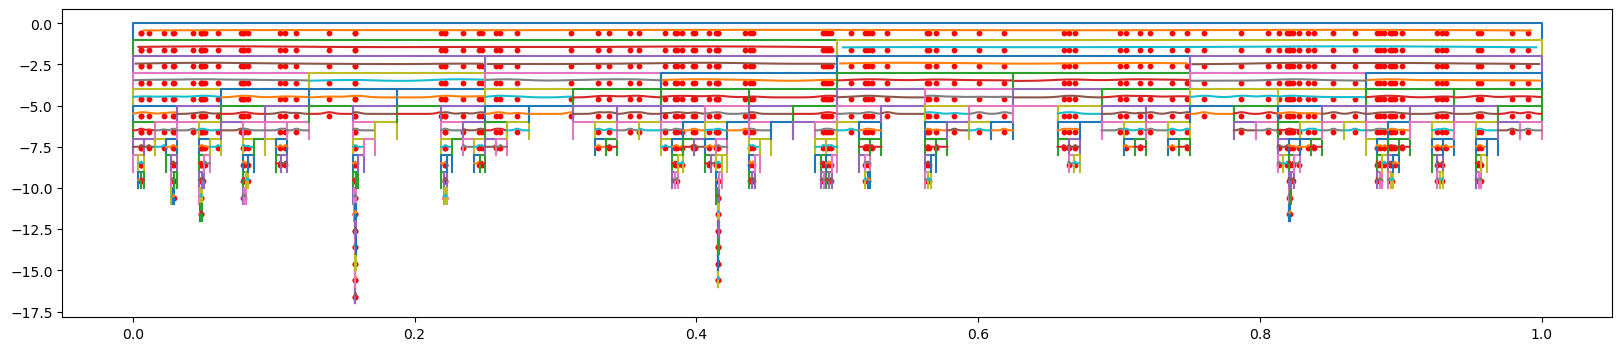

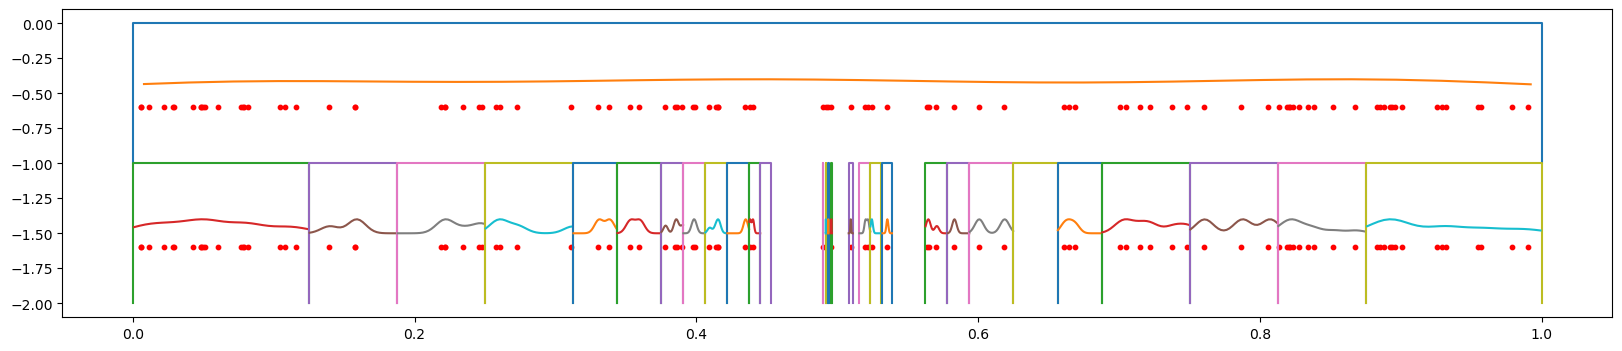

In [21]:
# DATA
key = jax.random.PRNGKey(0)
ratio = 0.3
N = 100
max_points = 1
center_x, width = 0.5, 1.0

i = np.arange(N)
x = jax.random.uniform(key, (N,), minval=center_x-width/2, maxval=center_x+width/2)
tree_1d = get_1d_tree(i, x, center_x, width, max_points=max_points, data_func=get_data_1d)


# test
if True:
    new_leaves_1d = flatten_around_point(x[10], ratio, tree_1d)
    new_leavy_tree_1d = {"children": new_leaves_1d, "data": tree_1d["data"]}
    x0_features = nodes_to_array(new_leaves_1d)

    plt.figure(figsize=(20, 4))
    plot_1d_tree(tree_1d, depth=0, data_plotter=data_plotter)

    plt.figure(figsize=(20, 4))
    plot_1d_tree(new_leavy_tree_1d, data_plotter=data_plotter)

In [22]:

training_data = []
data_error = []
print("Computing training data...")
for x0 in x:
    new_leaves_1d = flatten_around_point(x0, ratio, tree_1d)
    new_leaves_1d = [leaf for leaf in new_leaves_1d if is_far(leaf, x0, ratio)]
    x0_features = nodes_to_array(new_leaves_1d)
    x0_features = x0_features.at[:,-2].set(x0_features[:,-2] - x0)
    x0_features = x0_features.at[:,:-2].set(x0_features[:,:-2]/len(x))
    
    val = potential_from_points(x0, x) / len(x)
    fmm_val = potential_from_array(0., x0_features)
    error = jnp.abs(val - fmm_val)/jnp.abs(val)
    print(f"True value: {val:.2f}, FMM value: {fmm_val:.2f}, Rel. Error: {error:.2e} ===========", end='\r')
    data_error.append(error)
    training_data.append((x0_features, val))   
    
info_dict = {"num_points": N, "center_x": center_x, "width": width, "ratio": ratio, "max_points": max_points}
jnp.save('raw_data.npy', {"data": training_data, "info": info_dict})

Computing training data...
